<a target="_blank" href="https://colab.research.google.com/github/wbfrench1/barker_DATA606/blob/main/src/crf_models/CRF_NER_Model_w_Grid_Search.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [101]:
# Ran into the following error: AttributeError: 'CRF' object has no attribute 'keep_tempfiles'
# Used below resolution
#https://github.com/TeamHG-Memex/sklearn-crfsuite/issues/60
!pip install -U 'scikit-learn<0.24'
!pip install sklearn-crfsuite
!pip install eli5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [306]:
import os
!wget https://github.com/wbfrench1/barker_DATA606/blob/58cb8e7164c6170e6a1b4e7a2db6196882a9c3b7/src/crf_models/crf_functions_w2v.py?raw=true
os.rename('/content/crf_functions_w2v.py?raw=true', '/content/crf_functions_w2v.py')

--2023-04-22 18:33:03--  https://github.com/wbfrench1/barker_DATA606/blob/58cb8e7164c6170e6a1b4e7a2db6196882a9c3b7/src/crf_models/crf_functions_w2v.py?raw=true
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/wbfrench1/barker_DATA606/raw/58cb8e7164c6170e6a1b4e7a2db6196882a9c3b7/src/crf_models/crf_functions_w2v.py [following]
--2023-04-22 18:33:03--  https://github.com/wbfrench1/barker_DATA606/raw/58cb8e7164c6170e6a1b4e7a2db6196882a9c3b7/src/crf_models/crf_functions_w2v.py
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/wbfrench1/barker_DATA606/58cb8e7164c6170e6a1b4e7a2db6196882a9c3b7/src/crf_models/crf_functions_w2v.py [following]
--2023-04-22 18:33:03--  https://raw.githubusercontent.com/wbfrench1/barker_DATA606/58cb8e7164c6170e6a1b4e7a2db6196882

In [264]:
import eli5
import crf_functions_w2v as funcs
from google.colab import drive
import requests
import pandas as pd
import random
import numpy as np
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 150)
from sklearn.model_selection import train_test_split
import sklearn_crfsuite
import joblib
from sklearn_crfsuite import metrics as crf_metrics
import nltk
nltk.download('averaged_perceptron_tagger')
import seaborn as sns
import matplotlib.pyplot as plt
import urllib
import pickle
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
import scipy.stats
from collections import Counter
from gensim.models import word2vec
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# 1. Read in the Data

##   1.a. Read in the Sarkar data
##   1.b. Read in the movie data


In [3]:
df = pd.read_csv('https://github.com/wbfrench1/barker_DATA606/blob/05c1c56275fcaf7e4df300b578f65f62127dad18/data/movie_data.csv?raw=true')

# 2. Explore the Data

In [4]:
# Differentiate the question columns.  q_num is absoloute, while
## q_num_by_src is a numbering for each of the four, movie data
### sets
df.rename(columns={'quest_num':'q_num_by_src',
                   'label': 'postag',
                   'entity' : 'tag'}, inplace=True)

In [102]:
df.head()

,q_num_by_src,postag,word,pos,tag,source,q_num
0,1,o-outside,what,o,outside,eng_train,1
1,1,o-outside,movies,o,outside,eng_train,1
2,1,o-outside,star,o,outside,eng_train,1
3,1,b-actor,bruce,b,actor,eng_train,1
4,1,i-actor,willis,i,actor,eng_train,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322035 entries, 0 to 322034
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   q_num_by_src  322035 non-null  int64 
 1   postag        322035 non-null  object
 2   word          322034 non-null  object
 3   pos           322035 non-null  object
 4   tag           322035 non-null  object
 5   source        322035 non-null  object
 6   q_num         322035 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 17.2+ MB


In [54]:
df.tag.unique()

array(['outside', 'actor', 'year', 'title', 'genre', 'director', 'song',
       'plot', 'review', 'character', 'rating', 'trailer', 'award',
       'origin', 'relationship', 'quote'], dtype=object)

In [8]:
df.tag.value_counts()

outside         145975
plot             89414
actor            22326
genre            13479
year             10246
director          8798
rating            7969
title             7289
origin            5117
character         3187
relationship      2246
review            2141
quote             1339
award             1241
song              1110
trailer            158
Name: tag, dtype: int64

In [10]:
df['q_num'].nunique(), df['word'].nunique(), df['pos'].nunique(), df['tag'].nunique()

(21987, 15336, 3, 16)

# 3. Create features in the data

## 3.1 Convert Movie Data Format

In [17]:
df.head()

,q_num_by_src,postag,word,pos,tag,source,q_num
0,1,o-outside,what,o,outside,eng_train,1
1,1,o-outside,movies,o,outside,eng_train,1
2,1,o-outside,star,o,outside,eng_train,1
3,1,b-actor,bruce,b,actor,eng_train,1
4,1,i-actor,willis,i,actor,eng_train,1


In [18]:
# copy original data
df1 = df.copy()

In [19]:
df1.columns

Index(['q_num_by_src', 'postag', 'word', 'pos', 'tag', 'source', 'q_num'], dtype='object')

In [20]:
# remove the extra columns
df1.drop(columns=['q_num_by_src', 'pos', 'tag', 'source'], inplace=True)

In [21]:
df1.head()

,postag,word,q_num
0,o-outside,what,1
1,o-outside,movies,1
2,o-outside,star,1
3,b-actor,bruce,1
4,i-actor,willis,1


In [22]:
#convert the word format to string
#rename the columns to match the Sarkar Tool
df1.word = df1.word.astype(str)
df1.rename(columns={'q_num': 'Sentence #',
                    'word': 'Word',
                    'postag': 'Tag'}, inplace=True)

In [23]:
# check for null values
df1.loc[df1.Word.isnull()]

,Tag,Word,Sentence #


In [24]:
df1.dropna(inplace=True)

In [25]:
# create the part of speech (POS) variable
df1['POS'] = [pos for word, pos in nltk.pos_tag(df1['Word'])]

In [26]:
df1.head()

,Tag,Word,Sentence #,POS
0,o-outside,what,1,WP
1,o-outside,movies,1,NNS
2,o-outside,star,1,VBP
3,b-actor,bruce,1,NN
4,i-actor,willis,1,NN


In [28]:
# update the 'o-outside tag to o
df1['Tag'].replace({'o-outside': 'o'}, inplace=True)

In [29]:
df1.head()

,Tag,Word,Sentence #,POS
0,o,what,1,WP
1,o,movies,1,NNS
2,o,star,1,VBP
3,b-actor,bruce,1,NN
4,i-actor,willis,1,NN


In [31]:
agg_func = lambda s: [(w,p,t) for w, p, t in zip(s['Word'].values.tolist(),
                                                 s['POS'].values.tolist(),
                                                 s['Tag'].values.tolist()
                                                 )
                                                 ]

In [32]:
# create the initial data format list of tuples (Word, POS, Tag)
grouped_df1 = df1.groupby('Sentence #').apply(agg_func)
l_sentences = [s for s in grouped_df1]

In [33]:
# view the list of sentence lists, where each sentence is a list of word tuples
# in the order of the original sentence. 
l_sentences[0]

[('what', 'WP', 'o'),
 ('movies', 'NNS', 'o'),
 ('star', 'VBP', 'o'),
 ('bruce', 'NN', 'b-actor'),
 ('willis', 'NN', 'i-actor')]

In [35]:
# make the feature set
X = np.array([funcs.sent2features(s) for s in l_sentences], dtype=object)
# make the label set
y = np.array([funcs.sent2labels(s) for s in l_sentences], dtype=object)

In [41]:
# view the resulting feature of the first sentences first word
X[0][0]

{'bias': 1.0,
 'word.lower()': 'what',
 'word[-3:]': 'hat',
 'word[-2:]': 'at',
 'word.isupper': False,
 'word.istitle()': False,
 'word.isdigit()': False,
 'postag': 'WP',
 'postag[:2]': 'WP',
 'BOS': True,
 '+1:word.lower()': 'movies',
 '+1:word.istitle()': False,
 '+1:word.isupper': False,
 '+1:postag': 'NNS',
 '+1:postag[:2]': 'NN'}

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state= 42)
X_train.shape, X_test.shape

((17589,), (4398,))

# 4. Implement Model for Movie Data

In [80]:
labels = list(df1.Tag.unique())

sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)

In [ ]:
param_grid = [{'c1': [0.01, 0.1, 1], 'c2': [0.01, 0.1, 1]]
param_grid

In [63]:
param_grid = {'c1': scipy.stats.expon(scale=0.5),
              'c2': scipy.stats.expon(scale=0.05),
}
param_grid

{'c1': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x7fc8d541d4f0>,
 'c2': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x7fc8d4efd3a0>}

In [82]:
# https://sklearn-crfsuite.readthedocs.io/en/latest/tutorial.html
# define the model
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    max_iterations=50,
    all_possible_transitions=True
)

# define the scoring metric
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels)

In [85]:
# create the randomized search
rs = RandomizedSearchCV(crf, param_grid,
                        cv=2,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=3,
                        scoring=f1_scorer)

In [86]:
# search for the best regularization parameters
rs.fit(X_train, y_train)

Fitting 2 folds for each of 3 candidates, totalling 6 fits


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  4.3min finished


RandomizedSearchCV(cv=2,
                   estimator=CRF(algorithm='lbfgs',
                                 all_possible_transitions=True,
                                 keep_tempfiles=None, max_iterations=50),
                   n_iter=3, n_jobs=-1,
                   param_distributions={'c1': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fc8d541d4f0>,
                                        'c2': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fc8d4efd3a0>},
                   scoring=make_sco...=['o', 'b-actor', 'i-actor', 'b-year', 'b-title', 'b-genre', 'i-genre', 'b-director', 'i-director', 'b-song', 'i-song', 'b-plot', 'i-plot', 'b-review', 'b-character', 'i-character', 'b-rating', 'i-review', 'i-title', 'i-rating', 'b-trailer', 'i-trailer', 'i-year', 'b-award', 'i-award', 'b-origin', 'i-origin', 'b-relationship', 'i-relationship', 'b-quote', 'i-quote']),
                   verbose=1)

In [88]:
# crf = rs.best_estimator_
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'c1': 0.1895122714190105, 'c2': 0.0570615152905861}
best CV score: 0.8578180962362314
model size: 3.80M


In [89]:
rs.cv_results_

{'mean_fit_time': array([76.73994756, 77.68374991, 76.56080472]),
 'std_fit_time': array([0.89762783, 1.22006011, 0.19984758]),
 'mean_score_time': array([5.43666613, 5.37965679, 3.51191282]),
 'std_score_time': array([1.21734798, 1.15648246, 1.26948571]),
 'param_c1': masked_array(data=[0.1895122714190105, 0.6152809279801799,
                    0.40792979136574437],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_c2': masked_array(data=[0.0570615152905861, 0.057749088822697706,
                    0.01855649889089143],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'c1': 0.1895122714190105, 'c2': 0.0570615152905861},
  {'c1': 0.6152809279801799, 'c2': 0.057749088822697706},
  {'c1': 0.40792979136574437, 'c2': 0.01855649889089143}],
 'split0_test_score': array([0.85559046, 0.85351636, 0.8534617 ]),
 'split1_test_score': array([0.86004574, 0.86047061, 0.85982657]),
 'mean_t

Dark blue => 0.8566, dark red => 0.8578


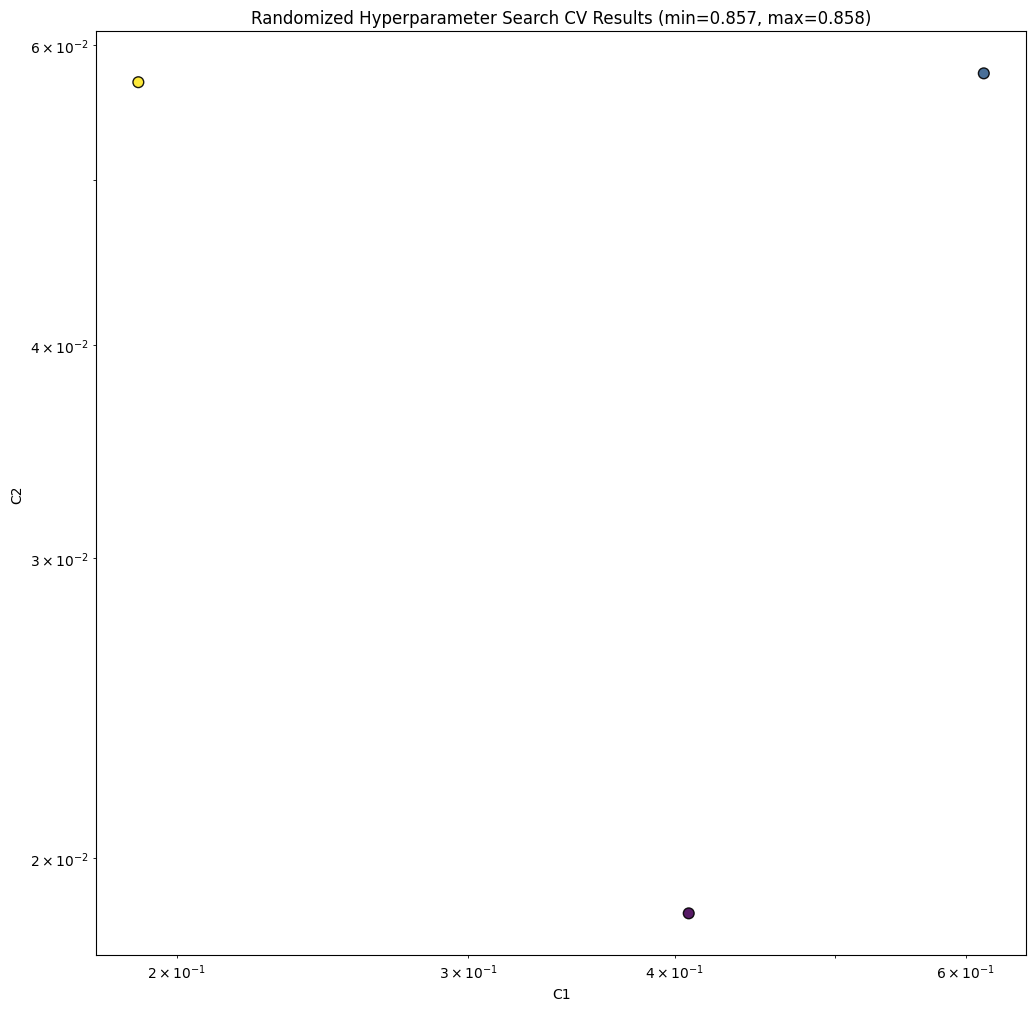

In [90]:
#https://stackoverflow.com/questions/61722752/attributeerror-randomizedsearchcv-object-has-no-attribute-grid-scores
_x = [s['c1'] for s in rs.cv_results_['params']]
_y = [s['c2'] for s in rs.cv_results_['params']]
_c = [s for s in rs.cv_results_['mean_test_score']]

fig = plt.figure()
fig.set_size_inches(12, 12)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_title("Randomized Hyperparameter Search CV Results (min={:0.3}, max={:0.3})".format(
    min(_c), max(_c)
))

ax.scatter(_x, _y, c=_c, s=60, alpha=0.9, edgecolors=[0,0,0])

print("Dark blue => {:0.4}, dark red => {:0.4}".format(min(_c), max(_c)))

In [91]:
crf = rs.best_estimator_
y_pred = crf.predict(X_test)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

                precision    recall  f1-score   support

             o      0.899     0.907     0.903     29657
       b-actor      0.921     0.930     0.926      2065
       i-actor      0.921     0.928     0.925      2417
       b-award      0.568     0.525     0.545        80
       i-award      0.655     0.692     0.673       195
   b-character      0.715     0.440     0.545       359
   i-character      0.697     0.487     0.573       269
    b-director      0.859     0.825     0.842       864
    i-director      0.874     0.834     0.853       880
       b-genre      0.887     0.883     0.885      1928
       i-genre      0.782     0.729     0.754       708
      b-origin      0.411     0.296     0.344       179
      i-origin      0.637     0.617     0.626       733
        b-plot      0.502     0.458     0.479      2027
        i-plot      0.854     0.911     0.882     14978
       b-quote      0.533     0.258     0.348        31
       i-quote      0.637     0.391     0.485  

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=['o', 'b-actor', 'i-actor', 'b-year', 'b-title', 'b-genre', 'i-genre', 'b-director', 'i-director', 'b-song', 'i-song', 'b-plot', 'i-plot', 'b-review', 'b-character', 'i-character', 'b-rating', 'i-review', 'i-title', 'i-rating', 'b-trailer', 'i-trailer', 'i-year', 'b-award', 'i-award', 'b-origin', 'i-origin', 'b-relationship', 'i-relationship', 'b-quote', 'i-quote'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Axes: >

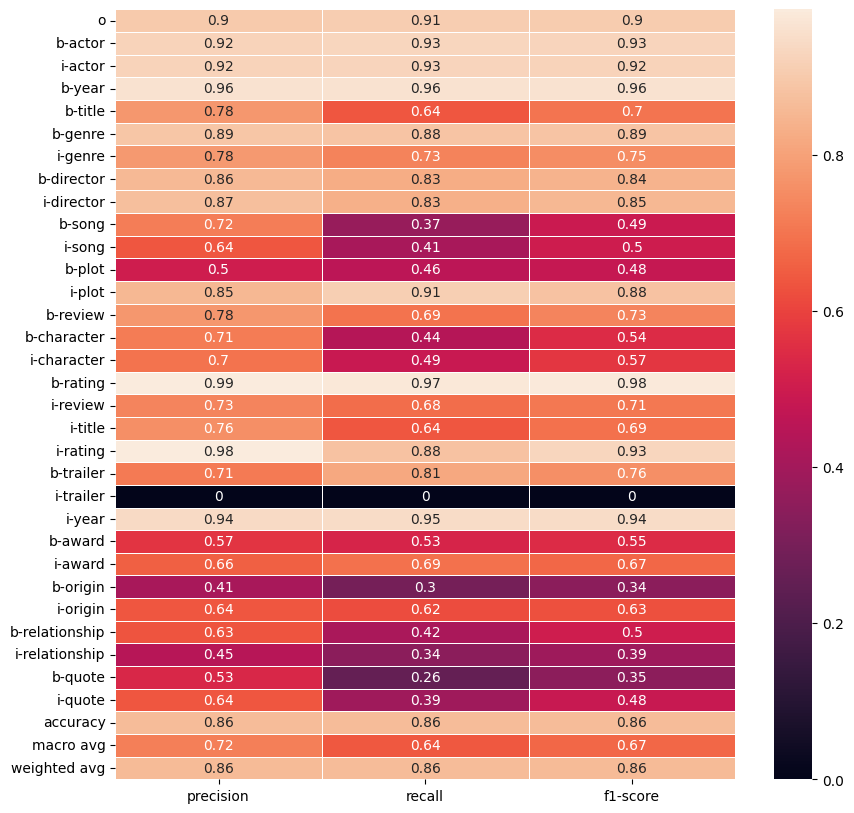

In [100]:
dict_class_report = dict(crf_metrics.flat_classification_report(y_test,y_pred, labels=labels, output_dict=True))

df_metrics = pd.DataFrame(dict_class_report).T
df_metrics.rename(index={'index': 'Tag'}, inplace=True)
df_metrics.head()

# https://stackoverflow.com/questions/28200786/how-to-plot-scikit-learn-classification-report
#https://stackoverflow.com/questions/38913965/make-the-size-of-a-heatmap-bigger-with-seaborn
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
sns.heatmap(df_metrics.iloc[:,:-1], annot=True, linewidths=.5, ax=ax)

In [99]:
def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(20))

print("\nTop unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-20:])

Top likely transitions:
i-song -> i-song  6.678912
b-song -> i-song  6.623759
b-origin -> i-origin 6.396950
i-origin -> i-origin 6.235651
b-title -> i-title 6.003217
i-relationship -> i-relationship 5.571336
b-actor -> i-actor 5.533003
b-director -> i-director 5.531364
i-title -> i-title 5.529734
i-plot -> i-plot  5.525668
i-quote -> i-quote 5.385240
b-relationship -> i-relationship 5.356188
i-year -> i-year  5.245745
b-character -> i-character 5.004146
b-quote -> i-quote 4.973391
i-genre -> i-genre 4.916115
b-plot -> i-plot  4.788665
i-review -> i-review 4.556898
b-genre -> i-genre 4.554838
i-character -> i-character 4.536156

Top unlikely transitions:
b-plot -> b-plot  -4.647508
i-genre -> b-genre -4.760610
i-actor -> i-plot  -4.872178
i-plot -> i-quote -4.982657
o      -> i-award -5.018490
o      -> i-rating -5.125572
i-plot -> i-character -5.146438
o      -> i-origin -5.305658
o      -> i-relationship -5.455474
o      -> i-genre -5.525335
o      -> i-director -5.587150
i-plot -> b-

In [97]:
#https://towardsdatascience.com/named-entity-recognition-and-classification-with-scikit-learn-f05372f07ba2
eli5.show_weights(crf, top=5)

From \ To,o,b-actor,i-actor,b-award,i-award,b-character,i-character,b-director,i-director,b-genre,i-genre,b-origin,i-origin,b-plot,i-plot,b-quote,i-quote,b-rating,i-rating,b-relationship,i-relationship,b-review,i-review,b-song,i-song,b-title,i-title,b-trailer,i-trailer,b-year,i-year
o,2.124,1.225,-6.343,0.419,-5.018,0.832,-5.714,0.889,-5.587,0.712,-5.525,0.887,-5.306,0.942,-7.577,0.449,-5.703,0.552,-5.126,0.445,-5.455,1.065,-6.252,0.978,-3.933,0.973,-5.881,-0.179,-4.412,0.751,-6.367
b-actor,-0.65,-3.0,5.533,-0.622,-1.957,-2.231,-2.561,-1.171,-2.822,-1.74,-1.487,-1.181,-1.632,-0.444,-3.294,-1.232,-1.553,-1.336,-0.949,-1.553,-1.376,-0.944,-2.131,-0.881,-0.709,-2.422,-1.979,-0.659,-0.364,-1.205,-1.206
i-actor,0.804,-4.624,3.324,0.01,-2.63,-1.834,-3.151,-3.419,-2.976,0.749,-2.452,-0.511,-2.511,0.863,-4.872,-1.715,-3.24,0.0,-2.1,-1.473,-2.521,0.113,-3.497,-0.386,-1.902,-2.473,-2.185,-0.898,-1.472,0.668,-2.089
b-award,-0.14,-1.041,-1.144,-0.038,4.373,-0.598,-0.593,-0.865,-0.739,-2.274,-0.501,-0.359,-0.406,-2.002,-1.899,-0.007,-0.293,-0.743,-0.091,-0.02,-0.327,-0.956,-0.952,-0.022,-0.001,-0.793,-0.536,-0.003,0.0,-0.015,-0.651
i-award,0.035,-0.194,-1.481,-0.144,4.302,-0.745,-0.764,-0.007,-1.317,-0.511,-1.164,0.076,-1.033,-1.376,-2.236,-0.029,-0.488,-0.51,-0.517,0.148,-0.647,-0.055,-1.131,-0.003,-0.129,-1.162,-1.003,-0.007,-0.0,-0.132,-0.816
b-character,-0.152,-1.405,-2.818,-0.465,-1.075,-2.387,5.004,-1.899,-2.374,-2.571,-1.316,-1.042,-1.354,1.844,-3.44,-0.58,-1.166,-1.065,-0.815,-0.819,-1.508,-2.213,-2.045,-0.65,-0.727,-1.558,-1.966,-0.535,-0.017,-1.386,-0.968
i-character,0.159,-0.671,-2.297,-0.415,-0.702,-1.376,4.536,-1.616,-1.489,-0.665,-0.948,-0.806,-1.18,1.654,-3.717,0.018,-0.834,-1.052,-0.737,-0.003,-1.36,-0.47,-2.184,-0.429,-0.492,-2.026,-2.3,-0.12,-0.003,-1.426,-1.101
b-director,-0.013,-2.648,-3.646,-0.559,-1.641,-1.512,-2.499,-2.899,5.531,-0.092,-2.075,-0.095,-1.694,-1.541,-2.774,-1.349,-1.685,-1.703,-1.3,0.019,-1.798,0.051,-2.047,-1.048,-0.755,0.011,-1.973,-0.606,-0.377,-0.133,-1.098
i-director,0.763,-1.86,-2.973,0.001,-2.93,-1.423,-2.405,-2.103,3.458,1.298,-2.319,-0.011,-2.053,-0.229,-3.346,-1.515,-1.849,0.076,-1.251,0.28,-1.809,0.494,-2.41,-1.323,-0.989,-1.69,-1.724,-0.616,-0.434,0.7,-1.675
b-genre,0.677,0.129,-3.543,0.0,-2.247,-1.674,-2.332,0.441,-2.971,-5.714,4.555,0.849,-2.078,0.375,-3.712,-1.374,-1.72,0.299,-1.806,0.752,-2.448,0.895,-3.068,-1.441,-1.355,-1.866,-2.313,-1.053,-0.924,0.815,-1.683


## Implement CRF with Word2Vec in feature vector

### Create Word2Vec vectors

In [105]:
# convert the list of sentence lists of word tuples into just a list
# sentences words
l_sents = [[tup[0] for tup in l_sent] for l_sent in l_sentences[0:]]

15337

In [149]:
print('sentence example 1:', l_sents[0])
print('sentence example 2:', l_sents[1])
print('number of sentences:', len(l_sents))
print ('number of unique words:' , len(set([word for sent in l_sents for word in sent ])))

sentence example 1: ['what', 'movies', 'star', 'bruce', 'willis']
sentence example 2: ['show', 'me', 'films', 'with', 'drew', 'barrymore', 'from', 'the', '1980s']
number of sentences: 21987
number of unique words: 15337


In [215]:
# define the parameters of word2vec model
feature_size = 12
window_context = 30
min_word_count = 1
sample = 1e-3

In [216]:
#instantiate the model
word2vec.Word2Vec()

In [217]:
# create the word2vec vectors
w2v_model = word2vec.Word2Vec(l_sents, 
                  vector_size= feature_size,
                  window = window_context,
                  min_count= min_word_count,
                  sample = sample,
                  )

In [218]:
# validate that words have vectors
w2v_model.wv['barrymore']

array([ 0.12319671, -0.05811715,  0.14390463, -0.29049644, -0.55821073,
        0.12548295, -0.03866561,  0.09155571, -0.06229092,  0.01219874,
        0.6523723 , -0.20038216], dtype=float32)

In [219]:
w2v_model.wv.similarity('fire', 'star')

0.67894644

In [297]:
funcs.create_w2v_feature_dict(w2v_model, 'barrymore')

{'w2v_0': 0.123196706,
 'w2v_1': -0.058117148,
 'w2v_2': 0.14390463,
 'w2v_3': -0.29049644,
 'w2v_4': -0.55821073,
 'w2v_5': 0.12548295,
 'w2v_6': -0.038665608,
 'w2v_7': 0.091555715,
 'w2v_8': -0.06229092,
 'w2v_9': 0.012198738,
 'w2v_10': 0.6523723,
 'w2v_11': -0.20038216}

In [221]:
w2v_model.wv.most_similar('bruce')

[('curtis', 0.9805041551589966),
 ('tony', 0.9773712158203125),
 ('harold', 0.9772618412971497),
 ('wonderful', 0.9739424586296082),
 ('jude', 0.9735686182975769),
 ('li', 0.9728450775146484),
 ('drew', 0.9727032780647278),
 ('emily', 0.9720001220703125),
 ('identical', 0.9693068265914917),
 ('metro', 0.9684173464775085)]

In [222]:
w2v_model.wv.get_normed_vectors()

array([[ 0.08263547,  0.09026546,  0.26358488, ...,  0.09672272,
         0.46088213,  0.11889126],
       [ 0.14518484,  0.01825657,  0.04291647, ...,  0.00555657,
         0.53124213,  0.01234598],
       [-0.042082  , -0.16278806, -0.03903707, ...,  0.045377  ,
         0.6190298 , -0.0993171 ],
       ...,
       [ 0.3086894 ,  0.49869922,  0.15107802, ..., -0.58180225,
        -0.03276809,  0.25073102],
       [-0.1561074 ,  0.30926   ,  0.3815264 , ..., -0.30284235,
         0.21987322, -0.12154023],
       [-0.32799047, -0.30155462, -0.17465404, ..., -0.14857578,
         0.23097908,  0.36654773]], dtype=float32)

In [ ]:
word = 'barrymore'
print('word2vec for', word, ' :', w2v_model.wv[word])
kmeans.predict([[ 0.12319671, -0.05811715,  0.14390463, -0.29049644, -0.55821073,
        0.12548295, -0.03866561,  0.09155571, -0.06229092,  0.01219874,
        0.6523723 , -0.20038216]])
funcs.create_w2v_feature_dict(w2v_model,'barrymore')

word2vec for barrymore  : [ 0.12319671 -0.05811715  0.14390463 -0.29049644 -0.55821073  0.12548295
 -0.03866561  0.09155571 -0.06229092  0.01219874  0.6523723  -0.20038216]


{'w2v_0': 0.123196706,
 'w2v_1': -0.058117148,
 'w2v_2': 0.14390463,
 'w2v_3': -0.29049644,
 'w2v_4': -0.55821073,
 'w2v_5': 0.12548295,
 'w2v_6': -0.038665608,
 'w2v_7': 0.091555715,
 'w2v_8': -0.06229092,
 'w2v_9': 0.012198738,
 'w2v_10': 0.6523723,
 'w2v_11': -0.20038216}

# Word2Vec: Create features in the data include W2V Vector

In [256]:
#grouped_df is a series NOT a dataframe
#each entry in the series is a list
# the elements in the list are tuples, 
#        - first entry is a sentence word
#        - second entry is a POS tag
#        - third entry is a IOB tag
grouped_df1[1]

[('what', 'WP', 'o'),
 ('movies', 'NNS', 'o'),
 ('star', 'VBP', 'o'),
 ('bruce', 'NN', 'b-actor'),
 ('willis', 'NN', 'i-actor')]

In [257]:
# Standard tokenized sentence with POS and NER tags
# list of lists of tuples, where the list contains sentences reprsented as lists.
# Each sentence list contains a word in the sentence along with the POS and NER
l_sentences = [s for s in grouped_df1]
l_sentences[0]

[('what', 'WP', 'o'),
 ('movies', 'NNS', 'o'),
 ('star', 'VBP', 'o'),
 ('bruce', 'NN', 'b-actor'),
 ('willis', 'NN', 'i-actor')]

In [274]:
import importlib
importlib.reload(funcs)

<module 'crf_functions_w2v' from '/content/crf_functions_w2v.py'>

In [275]:
funcs.word2features_w2v(l_sentences[0], 0, w2v_model)

{'bias': 1.0,
 'word.lower()': 'what',
 'word[-3:]': 'hat',
 'word[-2:]': 'at',
 'word.isupper': False,
 'word.istitle()': False,
 'word.isdigit()': False,
 'postag': 'WP',
 'postag[:2]': 'WP',
 'w2v_0': -0.058572777,
 'w2v_1': 1.511918,
 'w2v_2': 0.2826898,
 'w2v_3': -3.4769845,
 'w2v_4': -6.8811936,
 'w2v_5': 0.15645571,
 'w2v_6': -2.340244,
 'w2v_7': 1.5369458,
 'w2v_8': 0.66607004,
 'w2v_9': 0.48894614,
 'w2v_10': 0.85445887,
 'w2v_11': 2.324468,
 'BOS': True,
 '+1:word.lower()': 'movies',
 '+1:word.istitle()': False,
 '+1:word.isupper': False,
 '+1:postag': 'NNS',
 '+1:postag[:2]': 'NN'}

In [278]:
# make the feature set
X = np.array([funcs.sent2features_w2v(s, w2v_model) for s in l_sentences], dtype=object)
# make the label set
y = np.array([funcs.sent2labels(s) for s in l_sentences], dtype=object)

In [279]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state= 42)
X_train.shape, X_test.shape

((16490,), (5497,))

# 4. Implement Model for Movie Data

In [280]:
labels = list(df1.Tag.unique())

sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)

In [284]:
param_grid = [{'c1': [0.01, 0.1, 1], 'c2': [0.01, 0.1, 1]}]
param_grid

[{'c1': [0.01, 0.1, 1], 'c2': [0.01, 0.1, 1]}]

In [285]:
param_grid = {'c1': scipy.stats.expon(scale=0.5),
              'c2': scipy.stats.expon(scale=0.05),
}
param_grid

{'c1': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x7fc8570ea9a0>,
 'c2': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x7fc858be9c40>}

In [286]:
# https://sklearn-crfsuite.readthedocs.io/en/latest/tutorial.html
# define the model
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    max_iterations=50,
    all_possible_transitions=True
)

# define the scoring metric
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels)

In [287]:
# create the randomized search
rs = RandomizedSearchCV(crf, param_grid,
                        cv=2,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=3,
                        scoring=f1_scorer)

In [288]:
# search for the best regularization parameters
rs.fit(X_train, y_train)

Fitting 2 folds for each of 3 candidates, totalling 6 fits


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  5.8min finished


RandomizedSearchCV(cv=2,
                   estimator=CRF(algorithm='lbfgs',
                                 all_possible_transitions=True,
                                 keep_tempfiles=None, max_iterations=50),
                   n_iter=3, n_jobs=-1,
                   param_distributions={'c1': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fc8570ea9a0>,
                                        'c2': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fc858be9c40>},
                   scoring=make_sco...=['o', 'b-actor', 'i-actor', 'b-year', 'b-title', 'b-genre', 'i-genre', 'b-director', 'i-director', 'b-song', 'i-song', 'b-plot', 'i-plot', 'b-review', 'b-character', 'i-character', 'b-rating', 'i-review', 'i-title', 'i-rating', 'b-trailer', 'i-trailer', 'i-year', 'b-award', 'i-award', 'b-origin', 'i-origin', 'b-relationship', 'i-relationship', 'b-quote', 'i-quote']),
                   verbose=1)

In [289]:
# crf = rs.best_estimator_
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'c1': 0.03876491987237233, 'c2': 0.07703280613657917}
best CV score: 0.8568297859099508
model size: 4.20M


In [290]:
rs.cv_results_

{'mean_fit_time': array([ 98.61609364, 100.28901362,  78.38116944]),
 'std_fit_time': array([3.83121824, 4.19158483, 7.23802531]),
 'mean_score_time': array([7.2636255, 5.578035 , 3.7779125]),
 'std_score_time': array([2.04849446, 0.63171351, 1.12729704]),
 'param_c1': masked_array(data=[0.03876491987237233, 2.3765338037240102,
                    0.17758413952598742],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_c2': masked_array(data=[0.07703280613657917, 0.04524740181164377,
                    0.002529050022987938],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'c1': 0.03876491987237233, 'c2': 0.07703280613657917},
  {'c1': 2.3765338037240102, 'c2': 0.04524740181164377},
  {'c1': 0.17758413952598742, 'c2': 0.002529050022987938}],
 'split0_test_score': array([0.85389722, 0.84324056, 0.85443128]),
 'split1_test_score': array([0.85976235, 0.84940571, 0.85404474]),
 'me

Dark blue => 0.8463, dark red => 0.8568


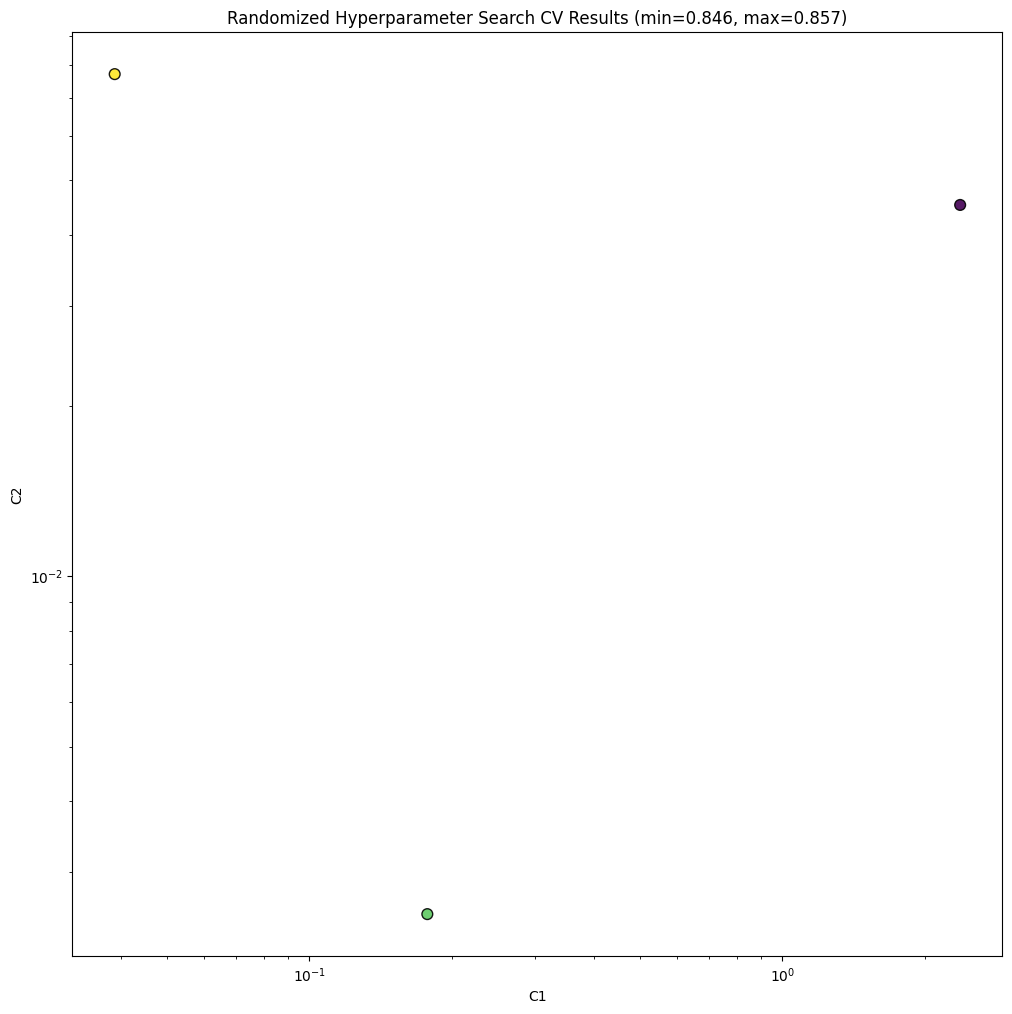

In [291]:
#https://stackoverflow.com/questions/61722752/attributeerror-randomizedsearchcv-object-has-no-attribute-grid-scores
_x = [s['c1'] for s in rs.cv_results_['params']]
_y = [s['c2'] for s in rs.cv_results_['params']]
_c = [s for s in rs.cv_results_['mean_test_score']]

fig = plt.figure()
fig.set_size_inches(12, 12)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_title("Randomized Hyperparameter Search CV Results (min={:0.3}, max={:0.3})".format(
    min(_c), max(_c)
))

ax.scatter(_x, _y, c=_c, s=60, alpha=0.9, edgecolors=[0,0,0])

print("Dark blue => {:0.4}, dark red => {:0.4}".format(min(_c), max(_c)))

In [292]:
crf = rs.best_estimator_
y_pred = crf.predict(X_test)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=['o', 'b-actor', 'i-actor', 'b-award', 'i-award', 'b-character', 'i-character', 'b-director', 'i-director', 'b-genre', 'i-genre', 'b-origin', 'i-origin', 'b-plot', 'i-plot', 'b-quote', 'i-quote', 'b-rating', 'i-rating', 'b-relationship', 'i-relationship', 'b-review', 'i-review', 'b-song', 'i-song', 'b-title', 'i-title', 'b-trailer', 'i-trailer', 'b-year', 'i-year'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                precision    recall  f1-score   support

             o      0.908     0.900     0.904     36962
       b-actor      0.920     0.938     0.929      2576
       i-actor      0.919     0.936     0.927      3010
       b-award      0.576     0.518     0.545       110
       i-award      0.717     0.663     0.689       267
   b-character      0.717     0.491     0.583       448
   i-character      0.661     0.559     0.606       345
    b-director      0.861     0.835     0.848      1076
    i-director      0.878     0.848     0.863      1096
       b-genre      0.876     0.891     0.883      2416
       i-genre      0.756     0.735     0.745       876
      b-origin      0.422     0.318     0.363       220
      i-origin      0.646     0.589     0.616       961
        b-plot      0.493     0.466     0.479      2565
        i-plot      0.847     0.918     0.881     19162
       b-quote      0.500     0.282     0.361        39
       i-quote      0.619     0.406     0.490  

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=['o', 'b-actor', 'i-actor', 'b-year', 'b-title', 'b-genre', 'i-genre', 'b-director', 'i-director', 'b-song', 'i-song', 'b-plot', 'i-plot', 'b-review', 'b-character', 'i-character', 'b-rating', 'i-review', 'i-title', 'i-rating', 'b-trailer', 'i-trailer', 'i-year', 'b-award', 'i-award', 'b-origin', 'i-origin', 'b-relationship', 'i-relationship', 'b-quote', 'i-quote'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


<Axes: >

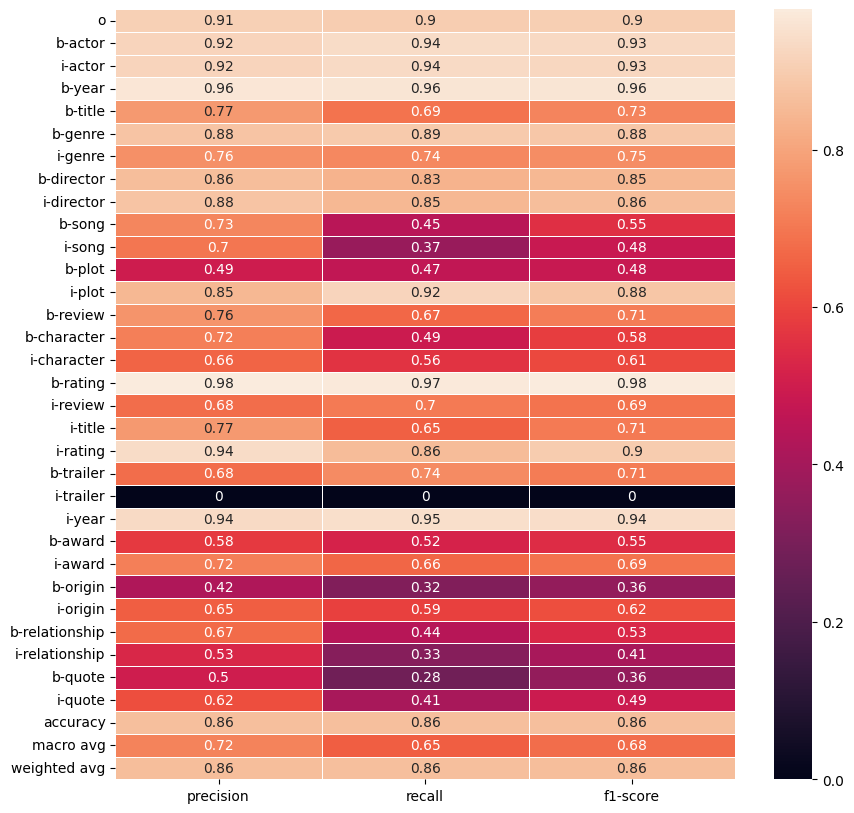

In [293]:
dict_class_report = dict(crf_metrics.flat_classification_report(y_test,y_pred, labels=labels, output_dict=True))

df_metrics = pd.DataFrame(dict_class_report).T
df_metrics.rename(index={'index': 'Tag'}, inplace=True)
df_metrics.head()

# https://stackoverflow.com/questions/28200786/how-to-plot-scikit-learn-classification-report
#https://stackoverflow.com/questions/38913965/make-the-size-of-a-heatmap-bigger-with-seaborn
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
sns.heatmap(df_metrics.iloc[:,:-1], annot=True, linewidths=.5, ax=ax)

In [294]:
def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(20))

print("\nTop unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-20:])

Top likely transitions:
b-actor -> i-actor 6.259807
b-title -> i-title 5.666640
b-director -> i-director 5.569578
i-quote -> i-quote 5.318741
i-origin -> i-origin 5.184726
i-year -> i-year  5.106901
i-title -> i-title 5.025584
b-relationship -> i-relationship 4.994908
b-origin -> i-origin 4.774343
b-year -> i-year  4.632376
i-relationship -> i-relationship 4.561268
b-character -> i-character 4.268296
b-song -> i-song  4.202225
i-review -> i-review 4.200752
b-award -> i-award 4.160649
i-song -> i-song  4.099445
b-review -> i-review 4.021149
i-award -> i-award 3.866949
i-actor -> i-actor 3.816956
i-plot -> i-plot  3.816799

Top unlikely transitions:
i-plot -> i-title -4.854263
i-plot -> i-character -5.042964
o      -> i-trailer -5.386699
b-genre -> b-genre -5.500204
i-actor -> i-plot  -5.625434
o      -> i-director -5.825471
o      -> i-song  -5.944837
o      -> i-title -6.049875
o      -> i-relationship -6.069539
o      -> i-year  -6.107360
i-plot -> b-plot  -6.117206
o      -> i-quote 

In [295]:
#https://towardsdatascience.com/named-entity-recognition-and-classification-with-scikit-learn-f05372f07ba2
eli5.show_weights(crf, top=5)

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


From \ To,o,b-actor,i-actor,b-award,i-award,b-character,i-character,b-director,i-director,b-genre,i-genre,b-origin,i-origin,b-plot,i-plot,b-quote,i-quote,b-rating,i-rating,b-relationship,i-relationship,b-review,i-review,b-song,i-song,b-title,i-title,b-trailer,i-trailer,b-year,i-year
o,1.501,0.616,-6.427,-0.015,-6.201,0.373,-6.447,0.648,-5.825,0.314,-7.061,0.451,-6.196,0.706,-8.283,0.331,-6.15,0.101,-6.676,0.035,-6.07,0.686,-6.714,0.369,-5.945,0.722,-6.05,0.177,-5.387,0.369,-6.107
b-actor,-0.159,-2.576,6.26,-0.638,-1.424,-2.209,-2.475,-0.641,-2.364,-1.432,-2.071,-1.096,-2.003,0.139,-3.362,-0.99,-1.777,-0.928,-1.292,-1.328,-1.445,-0.585,-1.828,-0.96,-1.8,-2.146,-1.837,-0.817,-0.591,-1.225,-1.166
i-actor,0.616,-4.737,3.817,-0.008,-2.886,-1.92,-3.27,-3.016,-3.092,0.668,-3.251,-0.276,-2.975,0.969,-5.625,-1.845,-3.252,-0.188,-2.847,-1.571,-2.729,0.009,-3.277,-0.691,-2.374,-2.335,-2.534,-0.394,-1.859,0.59,-2.361
b-award,-0.672,-2.276,-1.188,-1.162,4.161,-0.955,-1.261,-2.195,-1.01,-2.699,-1.647,-0.827,-1.279,-1.966,-2.598,-0.411,-1.001,-1.176,-0.691,-0.823,-1.085,-1.302,-1.803,-0.143,-0.847,-1.034,-0.906,-0.082,-0.038,-0.223,-0.563
i-award,-0.105,-0.987,-1.796,-2.253,3.867,-1.446,-1.536,-0.319,-1.19,-1.094,-2.289,0.004,-1.621,-2.57,-2.812,-0.611,-1.419,-0.548,-1.387,0.742,-1.64,-0.21,-2.115,0.028,-1.464,-1.33,-1.503,-0.486,-1.25,-0.872,-1.183
b-character,-0.079,-1.748,-2.736,-0.686,-1.644,-2.343,4.268,-1.946,-2.245,-2.602,-2.341,-1.471,-2.021,1.999,-4.022,-1.585,-2.368,-1.173,-1.503,-1.628,-1.821,-1.932,-1.772,-0.903,-1.643,-1.175,-2.241,-0.698,-0.903,-1.944,-1.179
i-character,0.084,-0.575,-1.979,-0.691,-1.511,-2.755,3.781,-1.257,-1.689,-1.304,-1.882,-1.108,-1.855,1.892,-4.456,0.017,-2.324,-1.543,-1.466,-0.087,-1.76,-1.729,-1.719,-0.532,-1.619,-2.162,-1.879,-0.486,-0.889,-1.41,-1.133
b-director,-0.199,-2.546,-3.179,-0.76,-1.674,-1.473,-2.56,-2.74,5.57,-0.207,-3.262,-0.207,-2.443,-1.199,-3.241,-1.588,-2.055,-1.634,-1.608,0.317,-1.851,0.112,-2.072,-1.183,-1.93,0.016,-2.04,-0.845,-0.903,-0.485,-1.311
i-director,0.466,-2.129,-2.808,-0.003,-2.325,-1.45,-2.083,-2.034,3.719,1.083,-3.735,-0.004,-2.526,-0.158,-4.22,-2.088,-2.713,-0.17,-2.087,0.027,-2.184,0.148,-2.342,-0.937,-1.711,-1.491,-2.023,-0.795,-1.016,0.776,-1.562
b-genre,0.669,-0.509,-3.045,-0.149,-2.654,-1.786,-2.991,0.666,-2.303,-5.5,3.274,0.66,-3.209,0.566,-4.462,-1.637,-2.609,0.274,-2.71,0.615,-3.011,0.772,-2.621,-1.946,-2.459,-2.596,-2.52,-1.076,-1.297,0.741,-1.758


# Cleanup below

In [ ]:
crf = sklearn_crfsuite.CRF(algorithm='lbfgs', c1= 0.1, c2= 0.1, max_iterations= 100, all_possible_transitions= True, verbose= True)
crf.fit(X_train, y_train)

loading training data to CRFsuite: 100%|██████████| 16490/16490 [00:06<00:00, 2700.08it/s]



Feature generation
type: CRF1d
feature.minfreq: 0.000000
feature.possible_states: 0
feature.possible_transitions: 1
0....1....2....3....4....5....6....7....8....9....10
Number of features: 91509
Seconds required: 1.470

L-BFGS optimization
c1: 0.100000
c2: 0.100000
num_memories: 6
max_iterations: 100
epsilon: 0.000010
stop: 10
delta: 0.000010
linesearch: MoreThuente
linesearch.max_iterations: 20

Iter 1   time=2.43  loss=533969.86 active=90028 feature_norm=1.00
Iter 2   time=1.22  loss=479375.01 active=87609 feature_norm=1.26
Iter 3   time=1.21  loss=453219.31 active=89020 feature_norm=1.58
Iter 4   time=1.20  loss=399874.22 active=88451 feature_norm=2.30
Iter 5   time=2.43  loss=384878.89 active=90303 feature_norm=2.98
Iter 6   time=1.61  loss=348582.20 active=90506 feature_norm=3.13
Iter 7   time=2.06  loss=335806.67 active=90569 feature_norm=3.63
Iter 8   time=1.28  loss=318625.75 active=90710 feature_norm=3.81
Iter 9   time=1.22  loss=305087.56 active=90630 feature_norm=4.28
Iter 

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.1,
    keep_tempfiles=None, max_iterations=100, verbose=True)

In [ ]:
joblib.dump(crf, 'crf_ner_movie_model.pkl')

['crf_ner_movie_model.pkl']

In [ ]:
y_pred = crf.predict(X_test)

In [ ]:
labels = crf.classes_
labels

['o',
 'b-genre',
 'b-director',
 'i-director',
 'b-title',
 'i-title',
 'b-year',
 'i-genre',
 'b-award',
 'i-award',
 'b-review',
 'b-plot',
 'i-plot',
 'i-review',
 'b-rating',
 'i-rating',
 'b-actor',
 'i-actor',
 'b-relationship',
 'i-year',
 'b-character',
 'i-character',
 'i-relationship',
 'b-origin',
 'i-origin',
 'b-quote',
 'i-quote',
 'b-song',
 'i-song',
 'b-trailer',
 'i-trailer']

In [ ]:
if 'o-outside' in labels:
    labels.remove('o-outside')
str_class_report = (crf_metrics.flat_classification_report(y_test,y_pred, labels=labels))
print(str_class_report)

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=['o', 'b-genre', 'b-director', 'i-director', 'b-title', 'i-title', 'b-year', 'i-genre', 'b-award', 'i-award', 'b-review', 'b-plot', 'i-plot', 'i-review', 'b-rating', 'i-rating', 'b-actor', 'i-actor', 'b-relationship', 'i-year', 'b-character', 'i-character', 'i-relationship', 'b-origin', 'i-origin', 'b-quote', 'i-quote', 'b-song', 'i-song', 'b-trailer', 'i-trailer'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


                precision    recall  f1-score   support

             o       0.91      0.90      0.91     36962
       b-genre       0.89      0.89      0.89      2416
    b-director       0.86      0.84      0.85      1076
    i-director       0.89      0.85      0.87      1096
       b-title       0.79      0.72      0.75       735
       i-title       0.77      0.68      0.73      1082
        b-year       0.96      0.96      0.96      1722
       i-genre       0.76      0.73      0.74       876
       b-award       0.59      0.52      0.55       110
       i-award       0.69      0.74      0.71       267
      b-review       0.77      0.71      0.74       935
        b-plot       0.50      0.48      0.49      2565
        i-plot       0.84      0.92      0.88     19162
      i-review       0.72      0.72      0.72       725
      b-rating       0.98      0.97      0.98       647
      i-rating       0.95      0.87      0.91       278
       b-actor       0.92      0.94      0.93  

In [ ]:
dict_class_report = dict(crf_metrics.flat_classification_report(y_test,y_pred, labels=labels, output_dict=True))

In [ ]:
df_metrics = pd.DataFrame(dict_class_report).T
df_metrics.rename(index={'index': 'Tag'}, inplace=True)
df_metrics.head()

,precision,recall,f1-score,support
o,0.914241,0.896407,0.905236,36962.0
b-genre,0.891970,0.891970,0.891970,2416.0
b-director,0.860266,0.841078,0.850564,1076.0
i-director,0.886342,0.846715,0.866076,1096.0
b-title,0.794872,0.717007,0.753934,735.0


<Axes: >

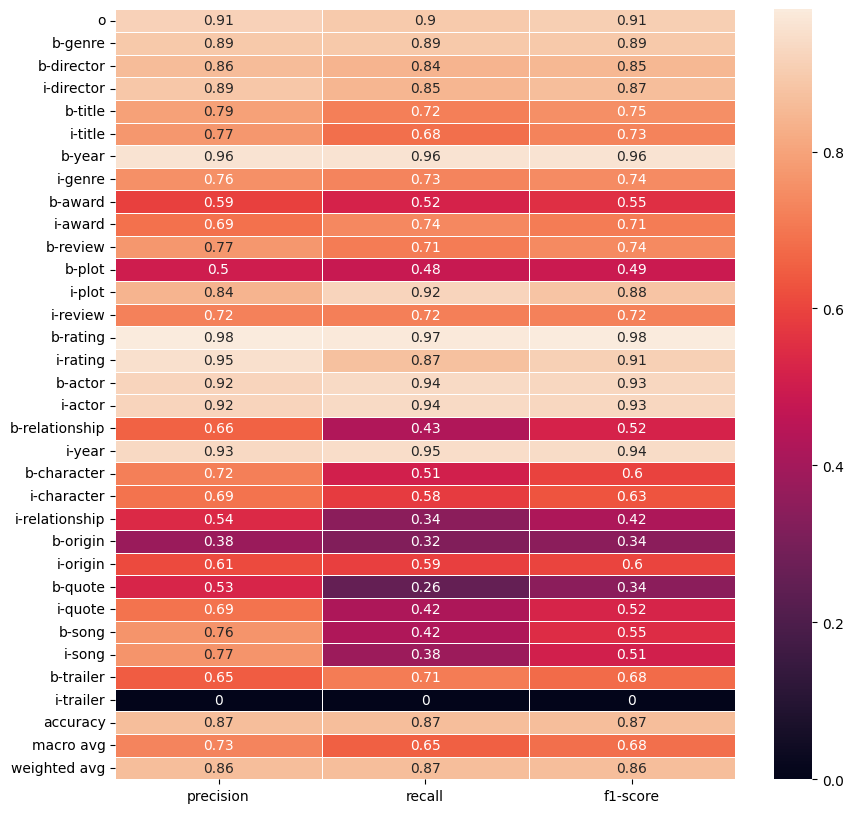

In [ ]:
# https://stackoverflow.com/questions/28200786/how-to-plot-scikit-learn-classification-report
#https://stackoverflow.com/questions/38913965/make-the-size-of-a-heatmap-bigger-with-seaborn
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
sns.heatmap(df_metrics.iloc[:,:-1], annot=True, linewidths=.5, ax=ax)

### Create Kmeans Word2Vec Clusters

In [ ]:
l_word_vector

array([ 0.63420355,  0.69276154,  2.0229383 , -0.26351306, -4.1805654 ,
       -2.608384  , -1.4453679 ,  1.8462855 ,  3.1911993 ,  0.74231917,
        3.5371382 ,  0.91245633], dtype=float32)

In [ ]:
# create a list of the word vectors
l_vectors = []
l_words = []
l_word_vector = []
i = 0
for word in w2v_model.wv.index_to_key:
    l_words.append(word)
    l_word_vector = w2v_model.wv[word]
    i += 1
print('number of word vectors:', i)

number of word vectors: 15337


In [ ]:
print('number of word labels:', len(kmeans.labels_))

number of word labels: 15337


In [ ]:
print('number of cluster labels:', len(set(kmeans.labels_)))

number of cluster labels: 1000


In [ ]:
# calculate the silhouette score for each cluster number
l_num_clus = []
l_silhouette_scores = []

for num_clus in [10, 20, 50, 100, 250, 500, 1000]:
    print(num_clus)
    kmeans = KMeans(n_clusters= num_clus)
    kmeans.fit_predict(l_vectors)
    l_num_clus.append(num_clus)
    l_silhouette_scores.append(silhouette_score(l_vectors, kmeans.labels_))

10
20
50
100
250
500
1000


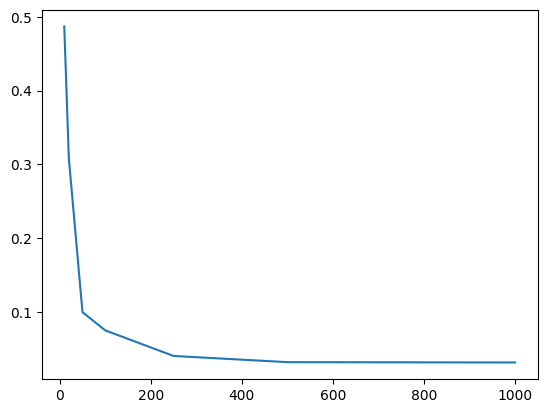

In [ ]:
import matplotlib.pyplot as plt
plt.plot(l_num_clus,l_silhouette_scores)

In [299]:
# create a word to cluster dictionary

# create a list to hold the words in the word2vec object
l_word_to_cluster = []
l_word_cluster_number = []
l_word_vector

i = 0

for word in w2v_model.wv.index_to_key:
    l_word_to_cluster.append(word)
    l_word_vector = w2v_model.wv[word]
    l_word_cluster_number.append(kmeans.predict([l_word_vector])[0])
    i += 1

dict_word_cluster = dict(zip(l_word_to_cluster,l_word_cluster_number))
list(dict_word_cluster.items())[:5]

[('the', 117), ('a', 88), ('movie', 96), ('what', 68), ('in', 98)]

In [304]:
def word2features_w2v_kmeans_clstr(l_sent: list, i, dict_word_cluster) -> dict:

    '''   Description:  Takes a sentence represented as a list of word tuples 
                        and an integer identifying the word tuple the function
                        will work on and returns a dictionary containing the 
                        words in each sentence and the corresponding features.
                        this function includes and additional feature: the 
                        kmeans cluster of the word2vec vector for each word
                        
                        l_sent: is formatted as a list of tuples where each 
                                 tuple is a:
                                   word in the sentence, 
                                   a part of speech tag,
                                   and an NER tag
                                   (word:str, POS:str, NER:str)
        
          Returns:      a dictionary, where each dictionary contains
                        features for one word in one sentence.
    
    '''
    word = l_sent[i][0]
    postag = l_sent[i][1]

    features = {'bias': 1.0,
                'word.lower()': word.lower(),
                'word[-3:]': word[-3:],
                'word[-2:]': word[-2:],
                'word.isupper': word.isupper(),
                'word.istitle()': word.istitle(),
                'word.isdigit()': word.isdigit(),
                'postag': postag,
                'postag[:2]': postag[:2],
               }
    
    features.update( {'kmeans_word2vec_clstr_num' : dict_word_cluster['movie']} )

    if i > 0:
        word1 = l_sent[i - 1][0]
        postag1 = l_sent[i - 1][1]
        features.update( {'-1:word.lower()': word1.lower(),
                          '-1:word.istitle()': word1.istitle(),
                          '-1:word.isupper': word1.isupper(),
                          '-1:postag': postag1,
                          '-1:postag[:2]': postag1[:2]
                          }
                        )
    
    else:
        features['BOS'] = True

    if i < len(l_sent) - 1:
        word1 = l_sent[i + 1][0]
        postag1 = l_sent[i + 1][1]
        features.update({'+1:word.lower()': word1.lower(),
                         '+1:word.istitle()': word1.istitle(),
                         '+1:word.isupper': word1.isupper(),
                         '+1:postag': postag1,
                         '+1:postag[:2]': postag1[:2]
                         }
                        )
    else:
        features['EOS'] = True
    
    return features


In [305]:
word2features_w2v_kmeans_clstr(l_sentences[0], 0, dict_word_cluster)

{'bias': 1.0,
 'word.lower()': 'what',
 'word[-3:]': 'hat',
 'word[-2:]': 'at',
 'word.isupper': False,
 'word.istitle()': False,
 'word.isdigit()': False,
 'postag': 'WP',
 'postag[:2]': 'WP',
 'kmeans_word2vec_clstr_num': 96,
 'BOS': True,
 '+1:word.lower()': 'movies',
 '+1:word.istitle()': False,
 '+1:word.isupper': False,
 '+1:postag': 'NNS',
 '+1:postag[:2]': 'NN'}